# 2D Quad-rotor control:
+ Linearizing about equlibrium point (hovering)
+ PD controller

In [1]:
import numpy as np
from math import sin, cos
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# PARAMETERS

In [2]:
# Constants
g       = 9.81;                # Gravitational acceleration (m/s^2)
m       = 0.18;                # Mass (kg)
Ixx     = 0.00025;             # Mass moment of inertia (kg*m^2)
L       = 0.086;               # Arm length (m)

t_span      = [0, 60];            # Simulation time (seconds) [from, to]
t_res       =  4*t_span[-1];
T_intervals = np.linspace(t_span[0],t_span[-1],t_res);

# Disturbing forces (External)

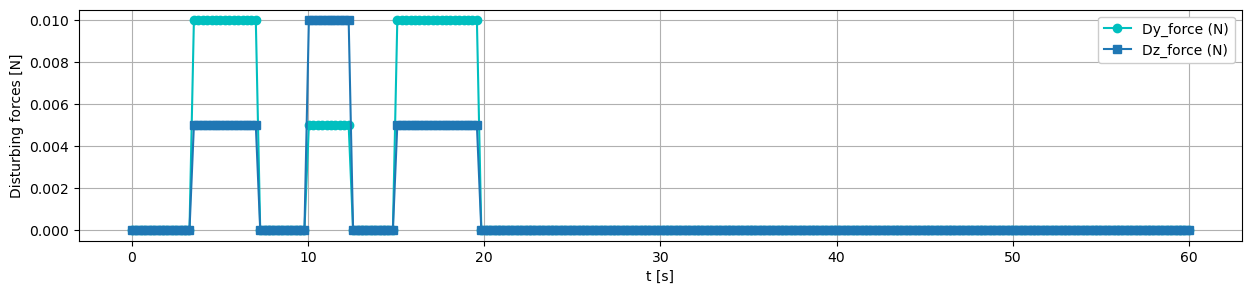

In [11]:
# Disutrbing forces in INERTIAL FRAME OF REFERENCE:
Dy_force = np.zeros_like(T_intervals);    Dz_force = np.zeros_like(T_intervals);

# SELECT ONE DISTRIBUTION WITH TIME:
Dy_force[14:29] = 1e-2;          Dz_force[14:29] = 5e-3;
Dy_force[40:50] = 5e-3;          Dz_force[40:50] = 1e-2;
Dy_force[60:79] = 1e-2;          Dz_force[60:79] = 5e-3;
# Dy_force = 0.1*(np.sin(T_intervals)+np.cos(2*T_intervals)); Dz_force = 0.1*(np.cos(T_intervals)+np.sin(2*T_intervals))
t2 = T_intervals[14:59]
# Dy_force[50:] = 0.0; Dz_force[50:]=0.0
# Dy_force[14:59] = np.sin(t2)+np.random.normal(loc=0.0, scale=0.01, size=t2.shape[0]); Dz_force[14:59] = np.sin(t2)+np.random.normal(loc=1.0, scale=0.01, size=t2.shape[0])
plt.figure(figsize=(15,3))
plt.plot(T_intervals,Dy_force, "co-", label="Dy_force (N)")
plt.plot(T_intervals,Dz_force,"s-", label="Dz_force (N)");
plt.xlabel("t [s]"); plt.ylabel("Disturbing forces [N]")
plt.legend(framealpha=1.0); plt.grid();

# DESIRED TRAJECTORY

In [4]:
# Returns the desired position, velocity, and acceleration at a given time.
# Trajectory is a step (y changes from 0 to 0.5 at t=1)
#
# t     : Time (seconds), scalar
# return: Desired position & velocity & acceleration, y, z, vy, vz, ay, az
def Target_trajectory(t:float):
    if t < 1:
        y = 0;
    else:
        y = 0.0;
    z = 2;
    vy = 0;
    vz = 0;
    ay = 0;
    az = 0;

    return (y, z, vy, vz, ay, az);


# CONTROLLER

In [5]:
# Returns force and moment to achieve desired state given current state.
# Calculates using PD controller.
#
# x     : Current state, [y, z, phi, vy, vz, phidot]
# y_des : desired y
# z_des : desired z
# vy_des: desired y velocity
# vz_des: desired z velocity
# ay_des: desired y acceleration
# az_des: desired z acceleration
# return: Force and moment to achieve desired state
# phi_dot_desired & phi_ddot_desired: is zero for small angle approximation
def PD_controller(x:list, g:float, y_des:float, z_des:float, vy_des:float, vz_des:float, ay_des:float, az_des:float):
    """
    PD_controller:
        Function helps estimate the required control input to motor\n
        for bringing motor to linearized equlibrium point/target point.

    fargs:
        >> x (list):        State vector for the drone
        >> g (float):       Accelecration due to gravity (m/s^2)
        >> y_des (float):   Desired/target y-position component for the drone (m)
        >> z_des (float):   Desired/target z-position component for the drone (m)
        >> vy_des (float):  Desired/target y-velocity component for the drone (m/s)
        >> vz_des (float):  Desired/target z-velocity component for the drone (m/s)
        >> ay_des (float):  Desired/target y-accleration component for the drone (m/s^2)
        >> ayzdes (float):  Desired/target z-accleration component for the drone (m/s^2)
    
    Return:
        >> F (float):       Scalar output --> Force required to control drone (N) -->   Body.Frame.Reference
        >> M (float):       Scalar output --> Moment required to control drone (Nm) --> Body.Frame.Reference
    """
    Kp_y   = 0.4;       #0.4
    Kv_y   = 1.0;       #1.0
    Kp_z   = 0.4;       #0.4
    Kv_z   = 1.0;       #1.0
    Kp_phi = 18.0;      #18.0 
    Kv_phi = 15.0;      #15.0
    
    phi_dot_des = 0.0; phi_ddot_des = 0.0;

    error_y         = (y_des        - x[0]);
    error_z         = (z_des        - x[1]);

    error_y_dot     = (vy_des       - x[3]);
    error_z_dot     = (vz_des       - x[4]);
    error_phi_dot   = (phi_dot_des  - x[5]);
    
    phi_c   = -(1/g) * (ay_des      + Kv_y * error_y_dot        + Kp_y * error_y);
    F       = m * (g + az_des       + Kv_z * error_z_dot        + Kp_z * error_z);
    M       = Ixx * (phi_ddot_des   + Kv_phi * error_phi_dot    + Kp_phi * (phi_c - x[2]));

    return (F, M);

# LIFT & MOMENT CLAMPING

In [6]:
# Limit force and moment to prevent saturating the motor
# Clamp F and M such that u1 and u2 are between 0 N and 1.7658 N
#
#  Fmotor1   Fmotor2
#  _____    _____
#    |________|
#
# F = motor1 + motor2
# M = (motor2 - motor1)*L
def clamp(F:float, M:float, L:float):
    """
    clamp:
        Function ensures the control effort required in kept with in the maximum allowed for the motors.\n
        In other words this function returns clamped force and moments if controller effore required saturates the motor.

    fargs:
        >> F (float):           Force required to control drone (N) -->   Body.Frame.Reference
        >> M (float):           Moment required to control drone (Nm) --> Body.Frame.Reference
    
    Return:
        >> F_clamped (float):   Scalar output --> Max Force allowed to control drone (N) -->   Body.Frame.Reference
        >> M_clamped (float):   Scalar output --> Max Moment allowed to control drone (Nm) --> Body.Frame.Reference
    """
    Fmotor1 = 0.5*(F - M/L);
    Fmotor2 = 0.5*(F + M/L);
    
    # if m1 < 0 or m1 > 1.7658 or m2 < 0 or m2 > 1.7658:
        # print(f'motor saturation {m1} {m2}')
    
    Fmotor1_clamped = min(max(0, Fmotor1), 1.7658);
    Fmotor2_clamped = min(max(0, Fmotor2), 1.7658);
    F_clamped = Fmotor1_clamped + Fmotor2_clamped;
    M_clamped = (Fmotor2_clamped - Fmotor1_clamped) * L;

    return (F_clamped, M_clamped);


# STATE SPACE EQUATION

In [7]:
# Equation of motion
# dx/dt = f(t, x)
#
# t     : Current time (seconds), scalar
# x     : Current state, [y, z, phi, vy, vz, phidot]
# return: First derivative of state, [vy, vz, phidot, ay, az, phidotdot]
def xdot(t:np.ndarray, x:list, m:float, Ixx:float, L:float, t_points:float, g:float):
    """
    xdot:
        Function defines the rhs of second-order governing differential equation for the 2D-Drone.

    fargs:
        >> t (ndarray):         Array of time instances (s)
        >> x (list):            State vector for the drone
        >> m (float):           Net mass of the drone (kg)
        >> Ixx (float):         Moment of Inertia about x-axis (kg-m^2)
        >> L (float):           Length of each arm (m)
        >> t_points (float):    Scalar time instant (s)
        >> g (float):           Acceleration due to gravity (m/s^2)
    
    Return:
        >> F (float):       Scalar output --> Force required to control drone (N) -->   Body.Frame.Reference
        >> M (float):       Scalar output --> Moment required to control drone (Nm) --> Body.Frame.Reference
    """

    Dy = np.interp(t, t_points, Dy_force);
    Dz = np.interp(t, t_points, Dz_force);

    y_des, z_des, vy_des, vz_des, ay_des, az_des = Target_trajectory(t);
    F, M = PD_controller(x, g, y_des, z_des, vy_des, vz_des, ay_des, az_des);
    F_clamped, M_clamped = clamp(F, M, L);

    # First derivative, xdot = [vy, vz, phidot, ay, az, phidotdot]
    return [x[3],
            x[4],
            x[5],
            (-F_clamped * sin(x[2]) / m)    + (Dy/m),
            (F_clamped * cos(x[2]) / m) - g + (Dz/m),
            M_clamped / Ixx];




# Solve

In [8]:
x0     = [0, 2, 0, 0, 0, 0] # Initial state [y0, z0, phi0, vy0, vz0, phidot0]

# Solve for the states, x(t) = [y(t), z(t), phi(t), vy(t), vz(t), phidot(t)]
sol = solve_ivp(xdot, t_span, y0=x0, method="RK45",t_eval=T_intervals, args=[m,Ixx,L,T_intervals,g])

# Output-Responses

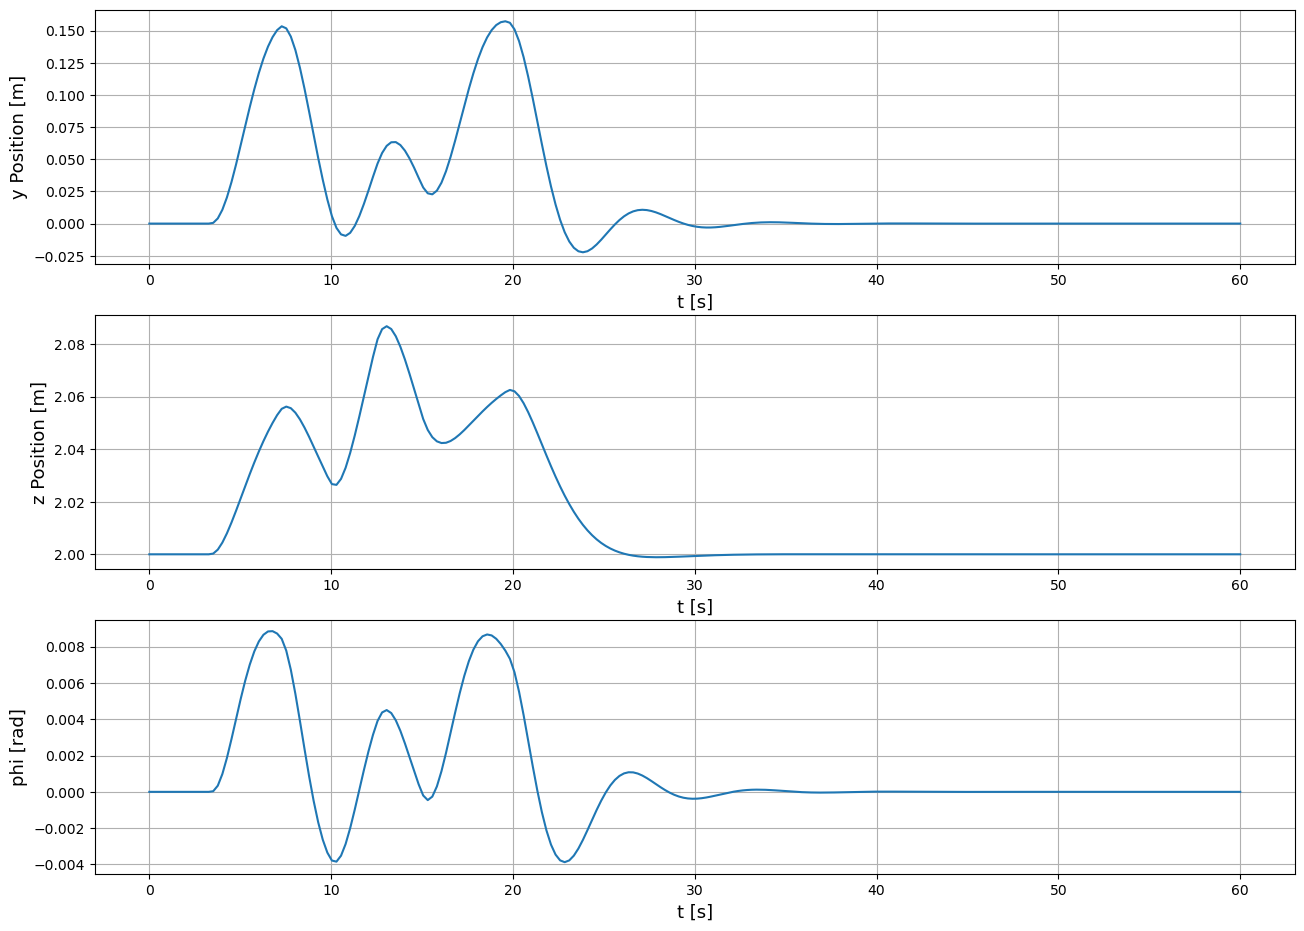

In [12]:
plt.figure(figsize=(12,3));
font_size = 13;
row = 3; col = 1;

plt.subplot(row,col,1);
plt.plot(sol.t, sol.y[0]); # y   vs t
plt.ylabel("y Position [m]", fontsize=font_size);
plt.xlabel("t [s]", fontsize=font_size);
plt.grid();
plt.subplots_adjust(left=-0.1, bottom = -1);


plt.subplot(row,col,2);
plt.plot(sol.t, sol.y[1]); # z   vs t
plt.ylabel("z Position [m]", fontsize=font_size);
plt.xlabel("t [s]", fontsize=font_size);
plt.grid();
plt.subplots_adjust(left=-0.1, bottom = -2);


plt.subplot(row,col,3);
plt.plot(sol.t, sol.y[2]); # phi vs t
plt.ylabel("phi [rad]", fontsize=font_size);
plt.xlabel("t [s]", fontsize=font_size);
plt.grid();

plt.show();